## EE4423 Machine Learning Project: Human Activity Recognition
This project will be doing PCA and multiclass classification (w/logistic regression) to recognize Human Activity using data gathered from sensors within smartphones (accelerometers, gyroscopes, etc).
The Human Activity Recognition database was built from the recordings of 30 study participants performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. I'm sure the data logging was similar to how the MATLAB mobile app does it as I presented in class!

The objective is to classify activities into one of the six activities performed!

Background Information from Kaggle regarding data processing: 
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import scipy.io
import sklearn
from sklearn import preprocessing, linear_model
%matplotlib inline

## Load the Training Data 

In [2]:
# import the training data from csv file
df = pd.read_csv('train.csv')
df.shape

(7352, 563)

In [3]:
df.head(6)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING
5,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,-0.942469,...,-0.844619,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126,1,STANDING


In the next cell, I set up the different classes from the training data. There are 6 possible classes, and the np.unique function converts it to a vector ytr with values of 0 to 5. 

In [4]:
#will use this later for logistic regression..
#setting up the different classes 
ystr = df['Activity'].values
vals,ytr = np.unique(ystr,return_inverse=True)

vals = np.reshape(vals,[6,1])
classkey = np.array([[0], [1], [2], [3], [4], [5]])

# here is a key of what the classes are and the corresponding class value
key = np.hstack((classkey,vals))
print(key)

[[0 'LAYING']
 [1 'SITTING']
 [2 'STANDING']
 [3 'WALKING']
 [4 'WALKING_DOWNSTAIRS']
 [5 'WALKING_UPSTAIRS']]


## SVD Practice on Smaller Set for Visualization!!

The following section is for visualizing some of the features. The two "classes" I took from the dataframe are the mean body acceleration in the x,y,and z directions (w.r.t. time), and the body acceleration energy in 3d as well. Visualizing the data in 3d scatter plot. In this following section I just want to visualize a smaller number of attributes of the samples. 

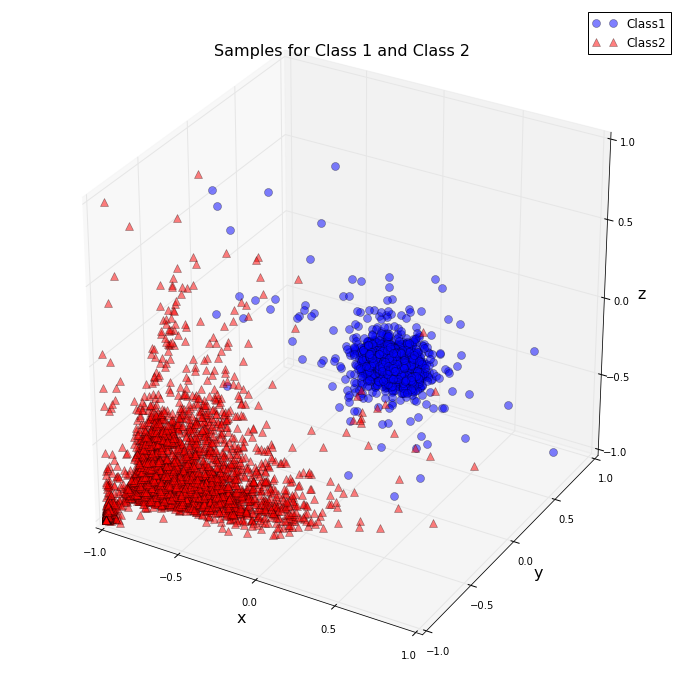

In [5]:
class1x = df['tBodyAcc-mean()-X'].values
class1y = df['tBodyAcc-mean()-Y'].values
class1z = df['tBodyAcc-mean()-Z'].values

samples = class1x.shape[0]

#reshape data 
class1x = np.reshape(class1x,[samples,1])
class1y = np.reshape(class1y,[samples,1])
class1z = np.reshape(class1z,[samples,1])

Class1 = np.hstack((class1x,class1y,class1z)).T

###
class2x = df['tBodyAcc-energy()-X'].values
class2y = df['tBodyAcc-energy()-Y'].values
class2z = df['tBodyAcc-energy()-Z'].values

#reshape this noww
class2x = np.reshape(class2x,[samples,1])
class2y = np.reshape(class2y,[samples,1])
class2z = np.reshape(class2z,[samples,1])

Class2 = np.hstack((class2x,class2y,class2z)).T

###
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.plot(Class1[0,:], Class1[1,:], Class1[2,:], 'o', markersize = 8, alpha=0.5, color='blue', label='Class1')
ax.plot(Class2[0,:], Class2[1,:], Class2[2,:], '^', markersize = 8, alpha=0.5, color ='red', label='Class2')

plt.title('Samples for Class 1 and Class 2',fontsize='16')
ax.legend(loc='upper right')
plt.xlabel('x',fontsize='16')
plt.ylabel('y',fontsize='16')
ax.set_zlabel('z',fontsize='16')

plt.show()

Merged the two matrices into one to practice SVD on a smaller matrix.. 

In [6]:
#merge samples
A = np.concatenate((Class1,Class2), axis=1)

'''
#compute d-dim mean vector
xmean = np.mean(All_samples[0,:]) #mean in the x direction
ymean = np.mean(All_samples[1,:])
zmean = np.mean(All_samples[2,:])

meanvec = np.array([[xmean],[ymean],[zmean]])
print('Mean Vector:\n',meanvec)
print(meanvec.shape)
'''

amean = (np.mean(A, axis = 1)).T
A0 = A - amean[:,None]


Now will take the SVD of A0:

In [7]:
u,s,v = scipy.linalg.svd(A0, full_matrices=False)
s.shape

(3,)

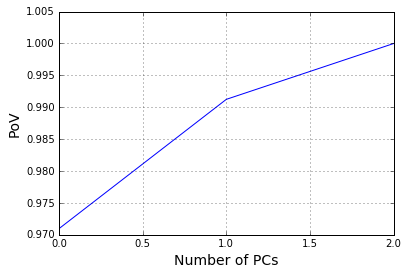

In [8]:
lam = s**2
pov = np.cumsum(lam)/np.sum(lam)

plt.plot(pov)
plt.grid()
#plt.axis([0,2,0.6,1.2])
plt.xlabel('Number of PCs', fontsize=14)
plt.ylabel('PoV',fontsize=14)

## Including All Features from Training Data

Now, will extract all the features from the dataframe to see how I can reduce the dimensionality. This includes the triaxial acceleration from the acclerometer on a phone, and the estimated body acceleration, the triaxial angular velocity from the gyroscope on the phone as well. There are features in terms of both the time and frequency domains. 

[[ 0.01409639 -0.00259874 -0.02376412 ..., -0.35169956  0.12134758
  -0.00211222]
 [ 0.00393071  0.00128486 -0.01437917 ..., -0.3552404   0.12169586
   0.00219799]
 [ 0.00516494 -0.00177173 -0.00432067 ..., -0.35938627  0.12204428
   0.00739689]
 ..., 
 [-0.00110075  0.00068481  0.06411919 ..., -0.28958541  0.19055181
   0.09732589]
 [ 0.01516604 -0.00114762 -0.04913957 ..., -0.29563422  0.1878392
   0.08185418]
 [ 0.07701535  0.00527231 -0.09472615 ..., -0.29371973  0.18821549
   0.09320955]]
(7352, 561)


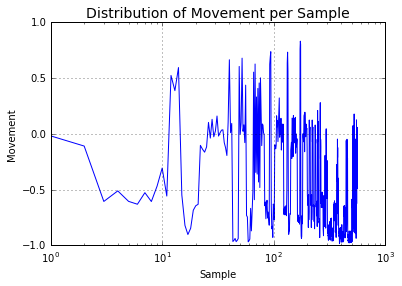

In [9]:
names = df.columns[:-2] #extracting all the features 

#will call the features matrix Mtr for training

Mtr = np.array(df[names].values)
mmean = np.mean(Mtr,axis=0)
Mtr0 = Mtr - mmean[None,:]
print(Mtr0)
print(Mtr0.shape)
plt.semilogx(mmean)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Movement')
plt.title('Distribution of Movement per Sample',fontsize=14)

Now will take the SVD

In [10]:
U,S,V = scipy.linalg.svd(Mtr0, full_matrices=False)
ncomps = S.shape[0]

Plot the proportion of variance versus the number of PCs

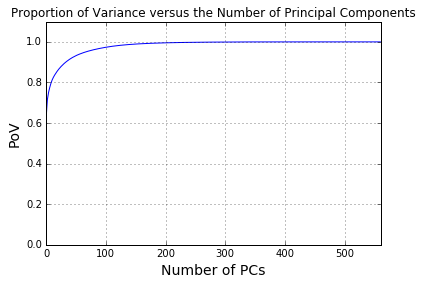

In [11]:
Lam = S**2
PoV = np.cumsum(Lam)/np.sum(Lam)

plt.plot(PoV)
plt.grid()
plt.axis([0,ncomps,0,1.1])
plt.xlabel('Number of PCs', fontsize=14)
plt.ylabel('PoV',fontsize=14)
plt.title('Proportion of Variance versus the Number of Principal Components')

The above PoV plot conveys that most variance is explained in approximately 200 components. 

Now I want to compute the coefficients of the data along the principal components.

In [12]:
Xtr = Mtr0.dot(V.T)

Will make logistic regression model based on the training data with p=200 principal components

In [13]:
p = 200 #value chosen based on the PoV plot!
logreg = linear_model.LogisticRegression(C=1e5)

In [14]:
Xtrs = preprocessing.scale(Xtr) #scale Xtr
logreg.fit(Xtrs[:,:p],ytr)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [15]:
#Measure accuracy of the classifier
ytr_hat = logreg.predict(Xtrs[:,:p])
acc = np.mean(ytr_hat == ytr)
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 1.000000


## Cross Validation of the Regression 

Will perform cross validation on the test data

## Load the Test Data

In [16]:
# import the test data from csv file
df1 = pd.read_csv('test.csv')
df1.shape

(2947, 563)

In [17]:
df1.head(6)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING
5,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,-0.857565,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471,2,STANDING


Same procedure as the training data part

In [18]:
ystrs = df1['Activity'].values
vals,yts = np.unique(ystrs,return_inverse=True)

vals = np.reshape(vals,[6,1])
classkey = np.array([[0], [1], [2], [3], [4], [5]])

# here is a key of what the classes are and the corresponding class value
key = np.hstack((classkey,vals))
print(key)

[[0 'LAYING']
 [1 'SITTING']
 [2 'STANDING']
 [3 'WALKING']
 [4 'WALKING_DOWNSTAIRS']
 [5 'WALKING_UPSTAIRS']]


In [19]:
names1 = df1.columns[:-2] #extracting all the features 

#will call the features matrix Mts for test!

Mts = np.array(df1[names1].values)
mmean1 = np.mean(Mts,axis=0)
Mts0 = Mts - mmean1[None,:]

Xts = Mts0.dot(V.T)

In [20]:
#Using the logistic regression model I learned on the training data
Xtss = preprocessing.scale(Xts)
yts_hat = logreg.predict(Xtss[:,:p])

In [21]:
accts = np.mean(yts_hat == yts)
print('Accuracy on the test data is {0:f}'.format(accts))

Accuracy on the test data is 0.948083


## Using 4-Fold Cross Validation on the Test Data

With 4-fold cross validation, the confusion matrix will be measured on the test data in each fold.
After adding the counts and normalizing the rows of the confusion matrix so that they sum to 1, each element in the matrix represents the fraction of samples where yhat==j given that ytrue==i

In [22]:
#first merge the test and training feature matrices into one big matrix Xs
Xs = np.vstack((Xtrs,Xtss))

#same with the outputs
yts = np.reshape(yts,[yts.shape[0],1])
ytr = np.reshape(ytr,[ytr.shape[0],1])

ys = np.vstack((ytr,yts))
ys = ys.ravel()

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

logreg = linear_model.LogisticRegression(C=1e3)

#initialize the confusion matrix counts
ny = np.max(ys)
C = np.zeros((ny+1,ny+1))

#create the cross-validation object
nfold = 4
kf = KFold(n_splits=nfold)
ns = Xs.shape[0]
Iperm = np.random.permutation(ns)

#loop over the folds in the cross-validation
for train, test in kf.split(Xs):
    
    #gotta get the training and test data 
    Itr = Iperm[train]
    Its = Iperm[test]
    Xtr = Xs[Itr,:p] #included the p here for 200 PC's
    ytr = ys[Itr]
    Xts = Xs[Its,:p] #p is here as well
    yts = ys[Its]
    
    #now fit a model
    logreg.fit(Xtr[:,:p], ytr)
    
    #predict the labels on the test set
    yhat = logreg.predict(Xts[:,:p])
    
    
    #add the counts to the confusion matrix
    C += confusion_matrix(yts,yhat)
    
#normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[np.newaxis,:]

#now print the confusion mtx
print('Confusion Matrix:')
print(np.array_str(C, precision=4, suppress_small=True))

#and the accuracy on the test data
testacc = accuracy_score(yts,yhat)
print('Accuracy = {0:.4f}'.format(testacc))


Confusion Matrix:
[[ 0.9954  0.0039  0.001   0.      0.      0.    ]
 [ 0.0031  0.9494  0.043   0.      0.      0.0013]
 [ 0.0005  0.0473  0.9538  0.0012  0.0007  0.    ]
 [ 0.      0.0006  0.0031  0.9942  0.0007  0.0013]
 [ 0.      0.0011  0.0047  0.0006  0.99    0.0013]
 [ 0.      0.0011  0.0016  0.0029  0.0014  0.9922]]
Accuracy = 0.9782
